In [16]:
# Default locations if parameter not passed
# benchmark_data_path = "tb-compare.pkl"
benchmark_data_path = "tb-compare-coaraci.pkl"

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from rich import print as rprint
import seaborn as sns
import os
import re
from scipy.stats import bootstrap

benchmark_data = pickle.load(open(benchmark_data_path, "rb"))

df = pd.DataFrame(benchmark_data["dataframe"])

sns.set_theme()

In [18]:
bench_names = df["name"].unique()
print(f"Benchmarks found: {bench_names}")
run_metadata = benchmark_data["config"].applications
n_runs = benchmark_data["config"].metadata.runs

df_bar = df[df["name"] == 'tb-compare']


n_runs = benchmark_data["config"].metadata.runs
print(f"Number of runs: {n_runs}")
print(df_bar.columns)
print(df_bar.head())

Benchmarks found: ['tb-compare']
Number of runs: 5
Index(['name', 'hosts', 'tb_path', 'full_output', 'ompc_tb_iter_num',
       'scheduler', 'kernel', 'type', 'image', 'iter', 'ompc_init_iter',
       'node_count', 'ompc_resch_iter', 'time'],
      dtype='object')
         name                                              hosts  \
0  tb-compare  r2n12,r2n13,r2n14,r2n15,r2n16,r2n17,r2n18,r2n1...   
1  tb-compare  r2n12,r2n13,r2n14,r2n15,r2n16,r2n17,r2n18,r2n1...   
2  tb-compare  r2n12,r2n13,r2n14,r2n15,r2n16,r2n17,r2n18,r2n1...   
3  tb-compare  r2n12,r2n13,r2n14,r2n15,r2n16,r2n17,r2n18,r2n1...   
4  tb-compare  r2n12,r2n13,r2n14,r2n15,r2n16,r2n17,r2n18,r2n1...   

        tb_path                                        full_output  \
0  tb-main-loop  [1750764775.121535] [r2n13:502473:0]        ib...   
1  tb-main-loop  [1750764786.517818] [r2n13:502560:0]        ib...   
2  tb-main-loop  [1750764797.376621] [r2n13:502636:0]        ib...   
3  tb-main-loop  [1750764808.737482] [r2n12:50

In [19]:
dump_to_csv = False

if dump_to_csv:
    csv_path = os.path.join(os.path.dirname(benchmark_data_path), "tb-compare.csv")
    print(f"Dumping to {csv_path}")
    df_bar.to_csv(csv_path, index=False)

In [20]:
# tb_time field (seconds)
# get total time from the output
def extract_elapsed_time(text):
    matches = re.findall(r"Elapsed Time ([\d.eE+-]+) seconds", text)
    if matches:
        # gets last mach
        # float() already handles scientific notation
        return float(matches[-1])
    return float('nan')

def extract_total_sched_time(text):
    # Find all "Scheduling : <number>"
    matches = re.findall(r"Scheduling\s*:\s*(\d+)", text)
    if not matches:
        print("No scheduling time found in the text:")
        print(text)
        return None
    total_microseconds = sum(int(m) for m in matches)
    return total_microseconds / 1e6  # microseconds to seconds

def map_schedueler_name(image_name):
    if "improv" in image_name:
        return "Record Replay"
    return "Baseline"

def map_scheduler(row):
    if 'improv' in row['image'].lower():
        return 'Record Replay'
    if row['scheduler'] == 'roundrobin':
        return 'Baseline-RR'
    if row['scheduler'] == 'heft':
        return 'Baseline-HEFT'
    return np.nan  # or 'Baseline-Unknown'

df_bar['tb_time'] = df_bar['full_output'].apply(extract_elapsed_time)
df_bar['sched_time'] = df_bar['full_output'].apply(extract_total_sched_time)
# worker nodes is node_count - 1
df_bar['worker_nodes'] = df_bar['node_count'].apply(lambda x: int(x - 1) if x > 1 else None)
# df_bench['scheduler_name'] = df_bench['image'].apply(map_schedueler_name)
df_bar['scheduler_name'] = df_bar.apply(map_scheduler, axis=1)

print(df_bar.columns)



No scheduling time found in the text:
[1750769756.950681] [r2n12:516140:0]        ib_verbs.h:87   UCX  ERROR ibv_exp_query_device(mlx5_0) returned 95: Operation not supported
[1750769756.953437] [r2n13:510526:0]        ib_verbs.h:87   UCX  ERROR ibv_exp_query_device(mlx5_0) returned 95: Operation not supported
Running Task Benchmark
  Configuration:
    Task Graph 1:
      Time Steps: 32
      Max Width: 32
      Dependence Type: stencil_1d
      Radix: 3
      Period: 0
      Fraction Connected: 0.250000
      Kernel:
        Type: load_imbalance
        Iterations: 1000
        Samples: 16
        Imbalance: 0.400000
      Output Bytes: 16
      Scratch Bytes: 0
Loop 0 : Elapsed time : 0.097275
Loop 1 : Elapsed time : 0.090434
Loop 2 : Elapsed time : 0.084766
Loop 3 : Elapsed time : 0.088026
Loop 4 : Elapsed time : 0.091575
Loop 5 : Elapsed time : 0.086379
Loop 6 : Elapsed time : 0.084807
Loop 7 : Elapsed time : 0.087864
Loop 8 : Elapsed time : 0.086500
Loop 9 : Elapsed time : 0.0816

# Experiment 1

freeze, for now:
kernel: compute_bound
type: fft

freeze:
ompc_tb_iter_num: 100
ompc_init_iter: 5
ompc_resch_iter: 0

y axsis: tb_time
x axis: worker node count 

one line per iter

Processing iteration: 1000
Processing type: stencil_1d


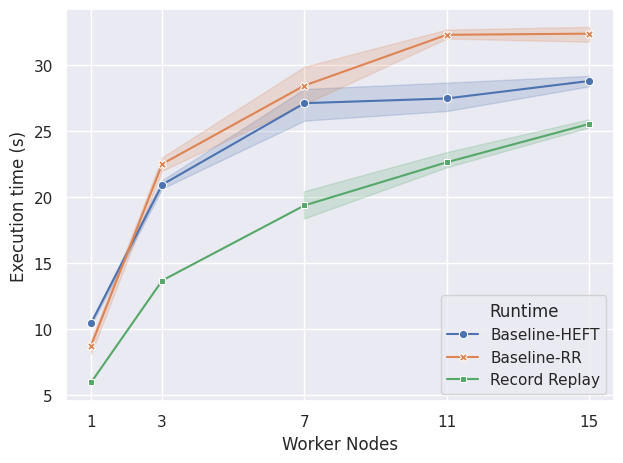

Processing iteration: 2000000
Processing type: stencil_1d


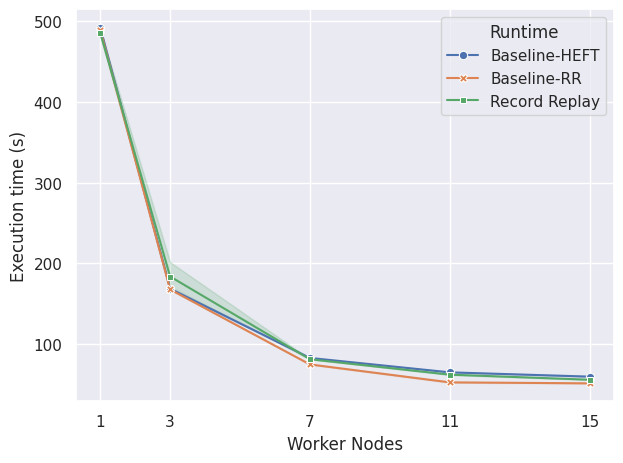

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

for iter in df_bar['iter'].unique():
  print(f"Processing iteration: {iter}")
  for type in df_bar['type'].unique():
    print(f"Processing type: {type}")
    ## TODO: keep doing this for kernel and ompc_tb_iter_num

    # apply filter for this loop
    df_plot = df_bar[(df_bar['iter'] == iter) & (df_bar['type'] == type)].copy()
    df_plot = df_plot[['tb_time', 'worker_nodes', 'scheduler_name']].copy()
    df_plot = df_plot.dropna() # worker nodes can be None if np = 1

    # 2) draw the plot
    plt.figure()
    sns.lineplot(
        data=df_plot,
        x='worker_nodes',
        y='tb_time',
        hue='scheduler_name',
        style='scheduler_name',
        markers=True,
        dashes=False,
        errorbar='ci',
    )

    plt.xlabel('Worker Nodes')
    plt.ylabel('Execution time (s)')
    #plt.title(f'{type.upper()} Dependency, {iter} iters. Elapsed time per worker node.')
    plt.xticks(sorted(df_plot['worker_nodes'].unique()))
    plt.legend(title='Runtime')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Experiment 2

Show two stacked bars per worker node count.
First stacked bar is: 'Record Replay' scheduler total scheduling stacked over interpolation

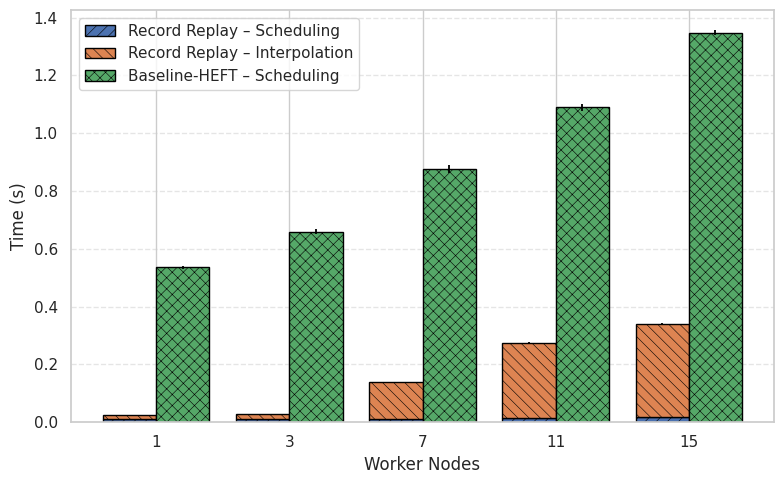

In [22]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
np.random.seed(0)

# ────────────────────────────────
# 1) helpers
# ────────────────────────────────
def extract_interpolation_time(txt: str) -> float:
    """Grab all 'Interpolation : <value>' hits (µs) and return sum in seconds."""
    hits = re.findall(r"Interpolation : ([\d.eE+-]+)", txt or "")
    return sum(map(float, hits)) / 1e6 if hits else 0.0


def ci_percentile_mean(data: np.ndarray, n_resamples: int = 2000,
                       ci: float = 95.0) -> tuple[float, float]:
    """Percentile bootstrap CI on the mean."""
    if len(data) < 2:
        m = data.mean() if len(data) else 0.0
        return m, m
    res = np.random.choice(data, size=(n_resamples, len(data)), replace=True)
    means = res.mean(axis=1)
    lo = np.percentile(means, (100 - ci) / 2)
    hi = np.percentile(means, 100 - (100 - ci) / 2)
    return lo, hi


# ────────────────────────────────
# 2) prepare dataframe
#    assumes you already have df_bar
# ────────────────────────────────
df = df_bar.copy()

df['interp_time'] = 0.0
rr_mask = df['scheduler_name'] == 'Record Replay'
df.loc[rr_mask, 'interp_time'] = df.loc[rr_mask, 'full_output']\
                                    .apply(extract_interpolation_time)

df['sched_time_remainder'] = df['sched_time'] - df['interp_time']
df = df.dropna(subset=['worker_nodes'])      # keep only valid rows

# keep one experiment
# pick one experiment from the dataset
# get list of types and iterations
ran_types = df['type'].unique()
ran_iters = df['iter'].unique()


ITER, TYPE = ran_iters[0], ran_types[0]  # change as needed
df = df[(df['iter'] == ITER) & (df['type'] == TYPE)]

# ────────────────────────────────
# 3) aggregate stats
# ────────────────────────────────
rows = []
for (nodes, sched), g in df.groupby(['worker_nodes', 'scheduler_name']):
    sched_vals  = g['sched_time_remainder'].to_numpy()
    interp_vals = g['interp_time'].to_numpy()
    tot_vals    = sched_vals + interp_vals

    # means
    mean_sched  = sched_vals.mean()
    mean_interp = interp_vals.mean()
    mean_total  = tot_vals.mean()

    # CI on TOTAL only
    lo_tot, hi_tot = ci_percentile_mean(tot_vals)

    rows.append({
        'worker_nodes':   nodes,
        'scheduler_name': sched,
        'sched_mean':     mean_sched,
        'interp_mean':    mean_interp,
        'total_mean':     mean_total,
        'total_lo':       lo_tot,
        'total_hi':       hi_tot,
    })

stats = pd.DataFrame(rows)

# ────────────────────────────────
# 4) pivot for plotting
# ────────────────────────────────
plt.rcParams['hatch.linewidth'] = 0.4
order = ['Record Replay', 'Baseline-HEFT']     # customise to taste
n_sched = len(order)
width   = 0.8 / n_sched
colors  = sns.color_palette('deep', n_sched * 2)
hatches = ['///', '\\\\\\', 'xxx','-', '/', 'x', '+', 'o', '.'] * n_sched

nodes = sorted(stats['worker_nodes'].unique())
x = np.arange(len(nodes))

def pivot(col):
    return (
        stats
        .pivot(index='worker_nodes', columns='scheduler_name', values=col)
        .loc[nodes, order]
        .to_numpy()
    )

sched_mean   = pivot('sched_mean')
interp_mean  = pivot('interp_mean')
total_mean   = pivot('total_mean')
total_lo     = pivot('total_lo')
total_hi     = pivot('total_hi')

# ────────────────────────────────
# 5) plot
# ────────────────────────────────
fig, ax = plt.subplots(figsize=(8, 5))

for i, name in enumerate(order):
    pos = x + (i - (n_sched - 1)/2) * width

    # scheduling block
    ax.bar(pos, sched_mean[:, i], width,
           color=colors[2*i], label=f'{name} – Scheduling', zorder=1, hatch=hatches[2*i], edgecolor='black')

    # interpolation block stacked
    if name != 'Baseline-HEFT':
      ax.bar(pos, interp_mean[:, i], width,
            bottom=sched_mean[:, i],
            color=colors[2*i+1], label=f'{name} – Interpolation', zorder=1,
            hatch=hatches[2*i+1], edgecolor='black')

    # vertical CI line on the total height
    ax.vlines(pos,
              total_lo[:, i],
              total_hi[:, i],
              colors='black',
              linewidth=1.3,
              zorder=3)

# cosmetics
ax.set_xticks(x)
ax.set_xticklabels(nodes)
ax.set_xlabel('Worker Nodes')
ax.set_ylabel('Time (s)')
#ax.set_title(f'FFT dependency – iters={ITER}, type={TYPE.upper()}')
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
